In [1]:
import numpy as np
import sys
sys.path.append("../")
from mlp import mlp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
import itertools
import datetime

## Loading data
### Remember that 1 means PD

In [2]:
data = pd.read_csv("../dataset/parkinsons.data")
data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


## Defining X and y

In [3]:
c = 0
for i in data.columns:
    print c, i 
    c+=1

0 name
1 MDVP:Fo(Hz)
2 MDVP:Fhi(Hz)
3 MDVP:Flo(Hz)
4 MDVP:Jitter(%)
5 MDVP:Jitter(Abs)
6 MDVP:RAP
7 MDVP:PPQ
8 Jitter:DDP
9 MDVP:Shimmer
10 MDVP:Shimmer(dB)
11 Shimmer:APQ3
12 Shimmer:APQ5
13 MDVP:APQ
14 Shimmer:DDA
15 NHR
16 HNR
17 status
18 RPDE
19 DFA
20 spread1
21 spread2
22 D2
23 PPE


In [4]:
print "total PD", data.status.values.tolist().count(1)
print "total no PD", data.status.values.tolist().count(0)
# as the number of PD and no PD is hugely different, resampling to get even amounts
pd_index = data.index[data.loc[:, "status"]==1]
nopd_index = data.index[data.loc[:, "status"]==0]
print pd_index.shape
print nopd_index.shape
#making data more even
my_index = np.hstack((pd_index[:48], nopd_index))
print my_index.shape

total PD 147
total no PD 48
(147,)
(48,)
(96,)


In [73]:
#X = scale(data.values[:, 1:].astype(np.float64)) #data[data.columns[[1, 2, 3]]].values
#y = data.status.values.astype(np.float64)#.reshape(-1,1)

################################################################################################
X = scale(data.values[my_index, 1:].astype(np.float64)) #data[data.columns[[1, 2, 3]]].values
y = data.status.values.astype(np.float64)[my_index]#.reshape(-1,1)
print X.shape, y.shape

(96, 23) (96,)


(67, 3) (14, 3) (15, 3)
(67,) (14,) (15,)


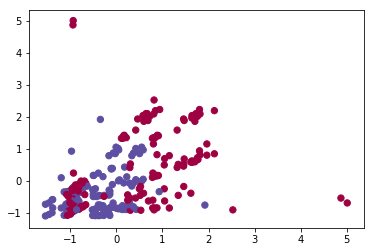

In [74]:
#15% for test, 15% for validating and 70% for training 
##seeding

np.random.seed(0)#0
X_data =  X[:, [0, 1,2]].astype(np.float64)#X[:, [22, 19, 0, 1]] #X[:, [22, 21, 20, 19]]  #X[:, [0,1,2]] 
myray = np.arange(X_data.shape[0])
np.random.shuffle(myray)


X_train = X_data[myray[:int(0.7*X_data.shape[0])],:]
X_test = X_data[myray[int(0.7*X_data.shape[0]):int(0.85*X_data.shape[0])],:]
X_validation = X_data[myray[int(0.85*X_data.shape[0]):],:]


y_train = y[myray[:int(0.7*X.shape[0])]]
y_test = y[myray[int(0.7*X.shape[0]):int(0.85*X.shape[0])]]
y_validation = y[myray[int(0.85*X.shape[0]):]]

print X_train.shape, X_test.shape, X_validation.shape
print y_train.shape, y_test.shape, y_validation.shape

plt.scatter(X_data[:,0], X_data[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.scatter(X_data[:,0], X_data[:,2], s=40, c=y, cmap=plt.cm.Spectral)
#plt.scatter(X_data[:,0], X_data[:,3], s=40, c=y, cmap=plt.cm.Spectral)
#plt.scatter(X_data[:,0], X_data[:,4], s=40, c=y, cmap=plt.cm.Spectral)

plt.scatter(X_data[:,1], X_data[:,2], s=40, c=y, cmap=plt.cm.Spectral)
#plt.scatter(X_data[:,1], X_data[:,3], s=40, c=y, cmap=plt.cm.Spectral)
#plt.scatter(X_data[:,1], X_data[:,4], s=40, c=y, cmap=plt.cm.Spectral) 

#plt.scatter(X_data[:,2], X_data[:,3], s=40, c=y, cmap=plt.cm.Spectral)
#plt.scatter(X_data[:,2], X_data[:,4], s=40, c=y, cmap=plt.cm.Spectral)

#plt.scatter(X_data[:,4], X_data[:,3], s=40, c=y, cmap=plt.cm.Spectral)

plt.show()

## Training and validating

CPU times: user 1.54 s, sys: 16.5 ms, total: 1.56 s
Wall time: 1.61 s
Training Error:  0.0340989457348
Validation Score:  0.986138412885
Validation R2score:  0.99257414976


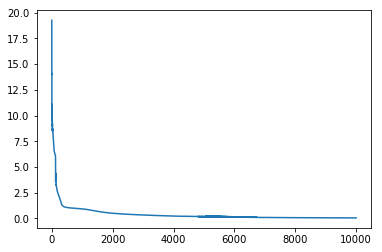

1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.9 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.8 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.1 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.1 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.2 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


In [79]:
clf = mlp(seed=0, activation="sigmoid", max_iter=10000, 
          hidden_layer_size=15, alpha=0.11, momentum=0.9, 
          tol=1e-10, weight_range=(-1,1), bias=True, classifier=False)

%time clf.fit(X_data, y)
print "Training Error: ", 1 - clf.score(X_train, y_train)

pred =  clf.predict(X_validation)
 
print "Validation Score: ", clf.score(X_validation, y_validation) 
print "Validation R2score: ", r2_score(y_validation, pred)

%matplotlib inline
plt.plot(clf.error_list)
#plt.ylim(0, 15)
plt.show()
pred = clf.predict(X_data)
for i in xrange(pred.shape[0]):
    print pred[i,0], y[i]

In [15]:
print "Validation:"
#print "Predicted Expected"
su = 0.
pred = clf.predict(X_validation)
for i in xrange(y_validation.shape[0]):
    #print pred[i][0], "       " , y_validation[i] 
    if  pred[i][0]== y_validation[i]:
        su = su+1
print su/float(y_validation.shape[0])

Validation:
0.933333333333


## Looking for the best

In [71]:
#looking for better parameters
tot = 100
sc = 0.5
j = 0
bestseed = 0
myrange = np.random.randint(0, 10000, (tot))
for i in myrange:
        st = datetime.datetime.now()
        clf = mlp(seed=i, activation="sigmoid", max_iter=10000, 
                  hidden_layer_size=15, alpha=0.1, momentum=0.9, 
                  tol=1e-10, weight_range=(-1,1), bias=True, classifier=False)

 
        clf.fit(X_data, y)
        predi =  clf.predict(X_data)
        r2 = clf.score(X_data, y)#r2_score(predi, y_validation)
        delta_t = datetime.datetime.now() - st
        if r2>sc:
            print "-------------------------------"
            """"
            print "new best found: ", r2, "seed", i
            print "Estimated remaining time: ", delta_t * (tot - j)
            print "Estimated finishing time: ", datetime.datetime.now() + delta_t * (tot - j)
            
            sc = r2 
            bestseed = i
            """
            if r2!=1.0:
                print "new best found: ", r2, "seed", i
                print "Estimated remaining time: ", delta_t * (tot - j)
                print "Estimated finishing time: ", datetime.datetime.now() + delta_t * (tot - j)
            
                sc = r2 
                bestseed = i
            else:
                print "Passing overfitting"
        j+=1
        
print "\n\n=======ended======\n\n"
print "Best seed found:", bestseed, "score:", sc
print "Finished at ", datetime.datetime.now()


for i in xrange(predi.shape[0]):
    print predi[i,0], y[i]



=======ended======


Best seed found: 0 score: 0.5
Finished at  2018-06-15 00:05:14.327460
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098 1.0
0.634538111098

## Little test with sklearn

In [13]:
from sklearn.neural_network import MLPClassifier
c = MLPClassifier(activation='tanh', max_iter=1000, hidden_layer_sizes=(12))
c.fit(X_train, y_train)
print c.score(X_validation, y_validation), r2_score(c.predict(X_validation), y_validation)

0.933333333333 0.732142857143


## Test

In [18]:
# plots the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    
    cnf_matrix = confusion_matrix(y_test, y_pred)
    classes = np.array(["No Parkinson", "Parkinson"])
    plt.clf()
    plt.close("all")
    #plt.figure(figsize = (7.5,6))
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #normalized
    cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, round(cnf_matrix[i, j], 3),
            horizontalalignment="center",
            color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Expected label')
    plt.xlabel('Predicted label')
    plt.show()
 
        

In [19]:
pred = clf.predict(X_test)
print "Test R2score: ", r2_score(pred, y_test)
print "Test score:", clf.score(X_test, y_test)
for i in xrange(pred.shape[0]):
    print pred[i,0], y_test[i]

Test R2score:  -22.1271089264
Test score: -0.772277513113
0.639999963106 1.0
0.428571434224 0.0
0.428571434224 1.0
0.639999963106 1.0
0.428571434224 0.0
0.639999963106 0.0
0.639999963106 0.0
0.428571434225 0.0
0.639999961983 1.0
0.639999963106 0.0
0.639999962762 0.0
0.428571434224 0.0
0.639999963106 1.0
0.428571434224 1.0


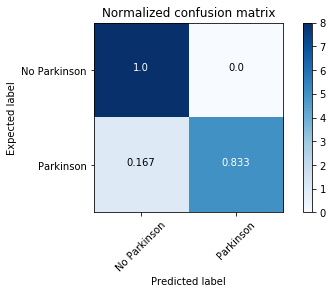

In [31]:
%matplotlib inline
plot_confusion_matrix(y_test, pred)

In [32]:
%matplotlib -l

Available matplotlib backends: ['osx', 'qt4', 'qt5', 'gtk3', 'notebook', 'wx', 'qt', 'nbagg', 'gtk', 'tk', 'inline']


In [51]:
print "Test R2score: ", r2_score(predi, y)

Test R2score:  0.566012006444


In [80]:
import pickle
f = open("pd.mlp", "w")
f.write(pickle.dumps(clf))
f.close()

In [88]:
clf.coefs[0].shape

(4, 15)

In [89]:
clf.coefs[1].shape

(16, 1)